## 第十章 ARCH&GARCH
以沪深300指数为例，考察其收益率时间的分布和统计特性。

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
#tsa为Time Series analysis缩写
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
#画图
import matplotlib.pyplot as plt
import tushare as ts
import matplotlib as mpl

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

# 定义画图函数
def ts_plot(data, lags=None,title=''):
    if not isinstance(data, pd.Series):
        data = pd.Series(data)
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0))
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        data.plot(ax=ts_ax)
        ts_ax.set_title(title+'时序图')
        smt.graphics.plot_acf(data, lags=lags,
              ax=acf_ax, alpha=0.5)
        acf_ax.set_title('自相关系数')
        smt.graphics.plot_pacf(data, lags=lags,
             ax=pacf_ax, alpha=0.5)
        pacf_ax.set_title('偏自相关系数')
        sm.qqplot(data, line='s', ax=qq_ax)
        qq_ax.set_title('QQ 图')
        scs.probplot(data, sparams=(data.mean(),
          data.std()), plot=pp_ax)
        pp_ax.set_title('PP 图')
        plt.tight_layout()
    return

# 使用tushare获取沪深300交易数据
token='此处输入个人token接口号'
pro=ts.pro_api(token)
df=pro.index_daily(ts_code='000300.SH')
df.index=pd.to_datetime(df.trade_date)
del df.index.name
df=df.sort_index()
df['ret']=np.log(df.close/df.close.shift(1))
#df.head()
ts_plot(df.ret.dropna(),lags=30,title='沪深300收益率')

ARCH模型的建模步骤：
1. 检验收益序列是否平稳，根据自相关性建立合适的均值方程，如ARMA模型，描述收益率如何随时间变化，根据拟合的模型和实际值，得到残差序列。
2. 对拟合的均值方程得到的残差序列进行ARCH效应检验，即检验收益率围绕均值的偏差是否时大时小。检验序列是否具有ARCH效应的方法有两种：Ljung-Box检验和LM检验。
3. 若ARCH效应在统计上显著，则需要再设定一个波动率模型来刻画波动率的动态变化。
4. 对均值方差和波动率方差进行联合估计，即假设实际数据服从前面设定的均值方差和波动率方差后，对均值方差和波动率方差中的参数进行估计，并得到估计的误差。
5. 对拟合的模型进行检验。如果估计结果（残差项）不满足模型本身的假设，则模型的可用性较差。

In [ ]:
# 模拟ARCH时间序列，对沪深300收益率的ARCH效应进行统计检验
np.random.seed(2)
a0 = 2
a1 = .5
y = w = np.random.normal(size=1000)
Y = np.empty_like(y)
for t in range(1,len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))
ts_plot(Y, lags=30,title='模拟ARCH')

def ret_plot(ts, title=''):
    ts1=ts**2
    ts2=np.abs(ts)
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(12, 6))
        layout = (2, 1)
        ts1_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        ts2_ax = plt.subplot2grid(layout, (1, 0))
        ts1.plot(ax=ts1_ax)
        ts1_ax.set_title(title+'日收益率平方')
        ts2.plot(ax=ts2_ax)
        ts2_ax.set_title(title+'日收益率绝对值')
        plt.tight_layout()
    return

ret_plot(df.ret.dropna(), title='沪深300')

# 使用Ljung-Box统计量对收益率平方的自相关性进行统计检验
def whitenoise_test(ts):
    '''计算box pierce 和 box ljung统计量'''
    from statsmodels.stats.diagnostic import acorr_ljungbox
    q,p=acorr_ljungbox(ts)
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(10, 4))
        axes = fig.subplots(1,2)
        axes[0].plot(q, label='Q统计量')
        axes[0].set_ylabel('Q')
        axes[1].plot(p, label='p值')
        axes[1].set_ylabel('P')
        axes[0].legend()
        axes[1].legend()
        plt.tight_layout()
    return

ret=df.ret.dropna()
whitenoise_test(ret**2)

实际应用中，GARCH(1,1)和GARCH(2,1)一般可以满足对自回归条件异方差的描述。下面使用Python对GARCH(1,1)模型进行模拟和估计

In [ ]:
# 模拟GARCH(1, 1) 过程
np.random.seed(1)
a0 = 0.2
a1 = 0.5
b1 = 0.3
n = 10000
w = np.random.normal(size=n)
garch = np.zeros_like(w)
sigsq = np.zeros_like(w)
for i in range(1, n):
    sigsq[i] = a0 + a1*(garch[i-1]**2) + b1*sigsq[i-1]
    garch[i] = w[i] * np.sqrt(sigsq[i])
_ = ts_plot(garch, lags=30,title='模拟GARCH')
# 使用模拟的数据进行 GARCH(1, 1) 模型拟合
#arch_model默认建立GARCH（1,1）模型
am = arch_model(garch)
res = am.fit(update_freq=0)

print(res.summary())

res.resid.plot(figsize=(12,5))
plt.title('沪深300收益率拟合GARCH(1,1)残差',size=15)
plt.show()
res.conditional_volatility.plot(figsize=(12,5),color='r')
plt.title('沪深300收益率条件方差',size=15)
plt.show()


## 第十一章 非线性随机过程

### 双线性检测（Bilinear model）

### 门限平滑移动自回归模型（Threshold and Smooth Transition Autoregressions）

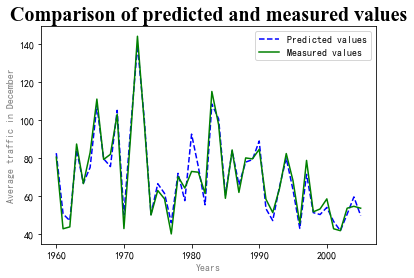

In [4]:
from sklearn.linear_model import LinearRegression
import pandas as pd
# 利用pandas读取csv，读取的数据为DataFrame对象
data = pd.read_csv('jl.csv')
# 将DataFrame对象转化为数组,数组的第一列为数据序号，最后一列为预报对象，中间各列为预报因子
data= data.values.copy()
# print(data)
# 计算互相关系数，参数为预报因子序列和滞时k
def get_regre_coef(X,Y,k):
    S_xy=0
    S_xx=0
    S_yy=0
    # 计算预报因子和预报对象的均值
    X_mean = np.mean(X)
    Y_mean = np.mean(Y)
    for i in  range(len(X)-k):
        S_xy += (X[i] - X_mean) * (Y[i+k] - Y_mean)
    for i in range(len(X)):
        S_xx += pow(X[i] - X_mean, 2)
        S_yy += pow(Y[i] - Y_mean, 2)
    return S_xy/pow(S_xx*S_yy,0.5)
#计算相关系数矩阵
def regre_coef_matrix(data):
    row=data.shape[1]#列数
    r_matrix=np.ones((1,row-2))
    # print(row)
    for i in range(1,row-1):
        r_matrix[0,i-1]=get_regre_coef(data[:,i],data[:,row-1],1)#滞时为1
    return r_matrix
r_matrix=regre_coef_matrix(data)
# print(r_matrix)
###输出###
#[[0.048979   0.07829989 0.19005705 0.27501209 0.28604638]]

#对相关系数进行排序找到相关系数最大者作为门限元
def get_menxiannum(r_matrix):
    row=r_matrix.shape[1]#列数
    for i in range(row):
        if r_matrix.max()==r_matrix[0,i]:
            return i+1
    return -1
m=get_menxiannum(r_matrix)
# print(m)
##输出##第五个因子的互相关系数最大

#根据门限元对因子序列进行排序,m为门限变量的序号
def resort_bymenxian(data,m):
    data=data.tolist()#转化为列表
    data.sort(key=lambda x: x[m])#列表按照m+1列进行排序(升序)
    data=np.array(data)
    return data
data=resort_bymenxian(data,m)#得到排序后的序列数组

# 将排序后的序列按照门限元分割序列为两段，第一分割第一段1个数据，第二段n-1（n为样本容量）个数据；第二次分割第一段2个数据，第二段n-2个数据，一次类推，分别计算出分割后的F统计量并选出最大统计量对应的门限元的分割点作为门限值
def get_var(x):
    return x.std() ** 2 * x.size  # 计算总方差
#统计量F的计算,输入数据为按照门限元排序后的预报对象数据
def get_F(Y):
    col=Y.shape[0]#行数，样本容量
    FF=np.ones((1,col-1))#存储不同分割点的统计量
    V=get_var(Y)#计算总方差
    for i in range(1,col):#1到col-1
        S=get_var(Y[0:i])+get_var(Y[i:col])#计算两段的组内方差和
        F=(V-S)*(col-2)/S
        FF[0,i-1]=F#此步需要判断是否通过F检验，通过了才保留F统计量
    return FF
y=data[:,data.shape[1]-1]
FF=get_F(y)
def get_index(FF,element):#获取element在一维数组FF中第一次出现的索引
    i=-1
    for item in FF.flat:
        i+=1
        if item==element:
            return i
f_index=get_index(FF,np.max(FF))#获取统计量F的最大索引
# print(data[f_index,m-1])#门限元为第五个因子，代入索引得门限值 121

# 以门限值为分割点将数据序列分割为两段，分别进行多元线性回归，此处利用sklearn.linear_model模块中的线性回归模块。再代入预报因子分别计算两段的预测值
#以门限值为分割点将新data序列分为两部分，分别进行多元回归计算
def data_excision(data,f_index):
    f_index=f_index+1
    data1=data[0:f_index,:]
    data2=data[f_index:data.shape[0],:]
    return data1,data2
data1,data2=data_excision(data,f_index)
# 第一段
def get_XY(data):
    # 数组切片对变量进行赋值
    Y = data[:, data.shape[1] - 1]  # 预报对象位于最后一列
    X = data[:, 1:data.shape[1] - 1]#预报因子从第二列到倒数第二列
    return X, Y
X,Y=get_XY(data1)
regs=LinearRegression()
regs.fit(X,Y)
# print('第一段')
# print(regs.coef_)#输出回归系数
# print(regs.score(X,Y))#输出相关系数
#计算预测值
Y1=regs.predict(X)
# print('第二段')
X,Y=get_XY(data2)
regs.fit(X,Y)
# print(regs.coef_)#输出回归系数
# print(regs.score(X,Y))#输出相关系数
#计算预测值
Y2=regs.predict(X)
Y=np.column_stack((data[:,0],np.hstack((Y1,Y2)))).copy()
Y=np.column_stack((Y,data[:,data.shape[1]-1]))
Y=resort_bymenxian(Y,0)

# 将预测值和实际值按照年份序号从新排序，恢复其顺序，利用matplotlib模块做出预测值与实际值得对比图
#恢复顺序
Y=resort_bymenxian(Y,0)
# print(Y.shape)
# 预测结果可视化
plt.plot(Y[:,0],Y[:,1],'b--',Y[:,0],Y[:,2],'g')
plt.title('Comparison of predicted and measured values',fontsize=20,fontname='Times New Roman')#添加标题
plt.xlabel('Years',color='gray')#添加x轴标签
plt.ylabel('Average traffic in December',color='gray')#添加y轴标签
plt.legend(['Predicted values','Measured values'])#添加图例
plt.show()


### 马尔可夫转换模型（Markov Switching Model）

In [8]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
#%是jupyter notebook的魔法命令
%matplotlib inline
#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
import tushare as ts
df=ts.get_k_data('sh',start='2000-01-01',end='2020-06-16')
df.index=pd.to_datetime(df.date)
df.head()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,date,open,close,high,low,volume,code
date,,,,,,,
2000-01-04,2000-01-04,1368.69,1406.37,1407.52,1361.21,9034020.0,sh
2000-01-05,2000-01-05,1407.83,1409.68,1433.78,1398.32,10580000.0,sh
2000-01-06,2000-01-06,1406.04,1463.94,1463.95,1400.25,13480500.0,sh
2000-01-07,2000-01-07,1477.15,1516.60,1522.82,1477.15,34515700.0,sh
2000-01-10,2000-01-10,1531.71,1545.11,1546.72,1506.40,31253500.0,sh


对收益率数据进行建模。此外，日收益率包含的噪声较大，将其转换为周收益率在进行建模

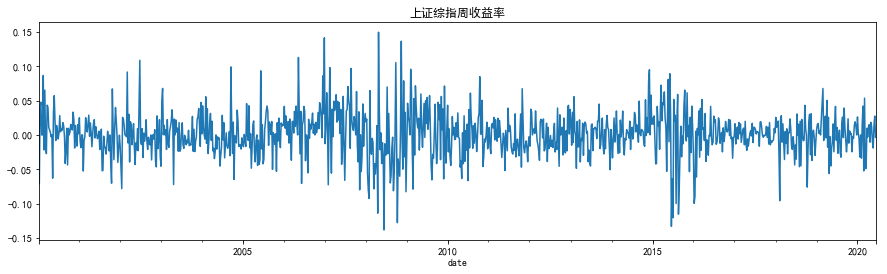

In [9]:
#上证综指周收益率
df_ret=df.close.resample('W').last().pct_change().dropna()
df_ret.plot(title='上证综指周收益率',figsize=(15,4))
plt.show()

平稳性检验

In [10]:
#使用arch包中的单位根检验unitroot导入ADF
from arch.unitroot import ADF
ADF(df_ret)

#模型拟合
mod = sm.tsa.MarkovRegression(df_ret.dropna(), 
k_regimes=3, trend='nc', switching_variance=True)
 
res = mod.fit()
res.summary()

D:\DataScience\Anaconda3-2019.3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  close   No. Observations:                 1067
Model:               MarkovRegression   Log Likelihood                2262.191
Date:                Tue, 11 Aug 2020   AIC                          -4506.382
Time:                        23:52:21   BIC                          -4461.628
Sample:                    01-16-2000   HQIC                         -4489.426
                         - 06-21-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   4.07e-05      8.235      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012      0.000      9.557      0.000       0.001       0.001
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0027      0.000      5.334      0.000       0.002       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9370      0.022     42.312      0.000       0.894       0.980
p[1->0]        0.1029      0.052      1.965      0.049       0.000       0.206
p[2->0]     6.929e-74      0.068   1.03e-72      1.000      -0.132       0.132
p[0->1]        0.0604      0.007      8.350      0.000       0.046       0.075
p[1->1]        0.8925      0.025     36.046      0.000       0.844       0.941
p[2->1]        0.0127      0.042      0.300      0.764      -0.070       0.096
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

对上证综指波动性状态的平滑概率进行可视化

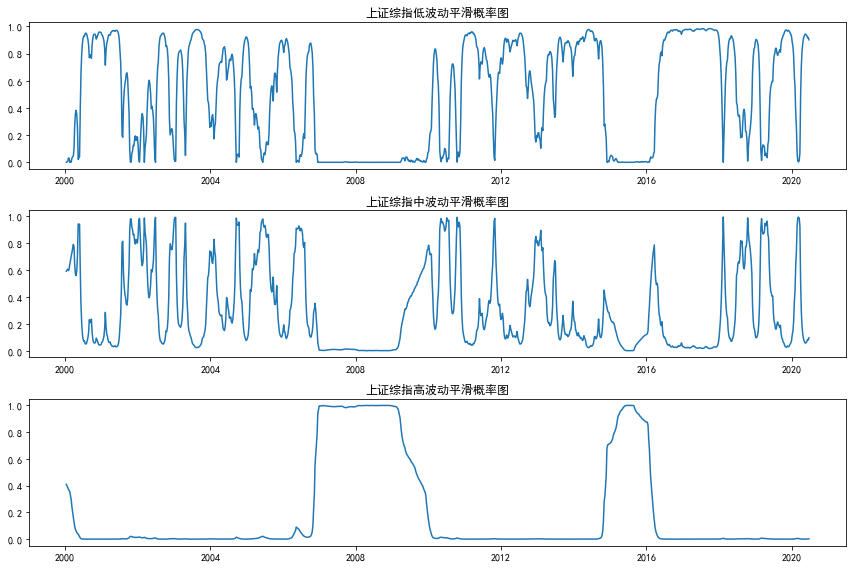

In [11]:
fig, axes = plt.subplots(3, figsize=(12,8))
ax = axes[0]
ax.plot(res.smoothed_marginal_probabilities[0])
ax.set(title='上证综指低波动平滑概率图')
ax = axes[1]
ax.plot(res.smoothed_marginal_probabilities[1])
ax.set(title='上证综指中波动平滑概率图')
ax = axes[2]
ax.plot(res.smoothed_marginal_probabilities[2])
ax.set(title='上证综指高波动平滑概率图')
fig.tight_layout()

具体情况

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


D:\DataScience\Anaconda3-2019.3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\DataScience\Anaconda3-2019.3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


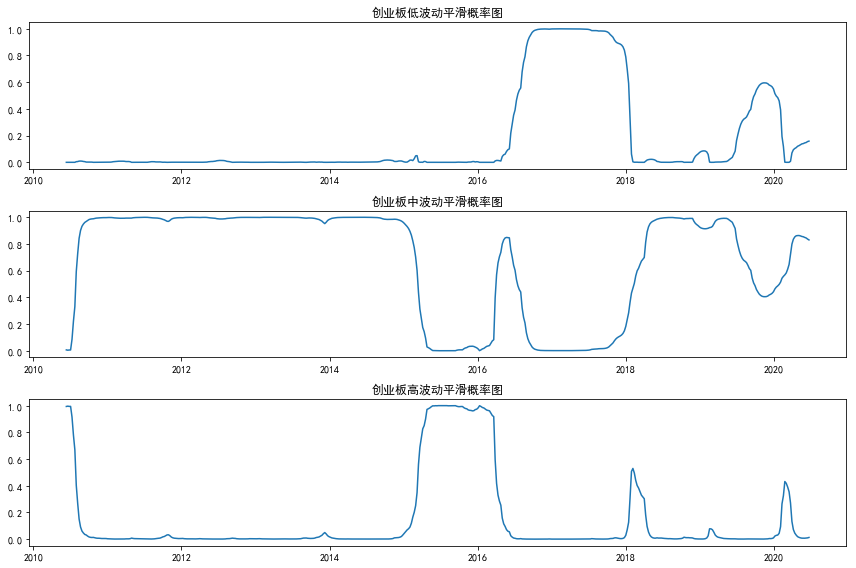

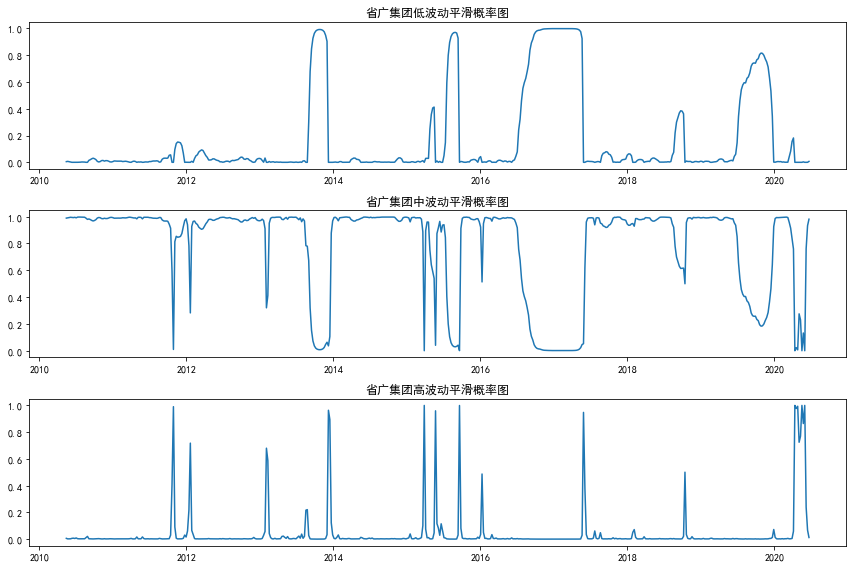

In [14]:
# 为了分析更多的指数或个股，下面将上述分析过程使用函数表示
def plot_rsm(code,title,start='2010-01-01',end='2020-06-17'):
    df=ts.get_k_data(code,start=start,end=end)
    df.index=pd.to_datetime(df.date)
    df_ret=df.close.resample('w').last().pct_change().dropna()
    #模型拟合
    mod = sm.tsa.MarkovRegression(df_ret.dropna(), k_regimes=3, trend='nc', switching_variance=True)
    res = mod.fit()
    fig, axes = plt.subplots(3, figsize=(12,8))
    ax = axes[0]
    ax.plot(res.smoothed_marginal_probabilities[0])
    ax.set(title=title+'低波动平滑概率图')
    ax = axes[1]
    ax.plot(res.smoothed_marginal_probabilities[1])
    ax.set(title=title+'中波动平滑概率图')
    ax = axes[2]
    ax.plot(res.smoothed_marginal_probabilities[2])
    ax.set(title=title+'高波动平滑概率图')
    fig.tight_layout()
    
plot_rsm('cyb','创业板')
plot_rsm('002400','省广集团')


### 非线性检测（BDS Test）

In [19]:
import numpy as np
from scipy import stats
from statsmodels.tools.validation import array_like

def distance_indicators(x, epsilon=None, distance=1.5):
    x = array_like(x, 'x')

    if epsilon is not None and epsilon <= 0:
        raise ValueError("Threshold distance must be positive if specified."
                         " Got epsilon of %f" % epsilon)
    if distance <= 0:
        raise ValueError("Threshold distance must be positive."
                         " Got distance multiplier %f" % distance)
    if epsilon is None:
        epsilon = distance * x.std(ddof=1)

    return np.abs(x[:, None] - x) < epsilon


def correlation_sum(indicators, embedding_dim):
    if not indicators.ndim == 2:
        raise ValueError('Indicators must be a matrix')
    if not indicators.shape[0] == indicators.shape[1]:
        raise ValueError('Indicator matrix must be symmetric (square)')

    if embedding_dim == 1:
        indicators_joint = indicators
    else:
        corrsum, indicators = correlation_sum(indicators, embedding_dim - 1)
        indicators_joint = indicators[1:, 1:]*indicators[:-1, :-1]

    nobs = len(indicators_joint)
    corrsum = np.mean(indicators_joint[np.triu_indices(nobs, 1)])
    return corrsum, indicators_joint


def correlation_sums(indicators, max_dim):
    corrsums = np.zeros((1, max_dim))

    corrsums[0, 0], indicators = correlation_sum(indicators, 1)
    for i in range(1, max_dim):
        corrsums[0, i], indicators = correlation_sum(indicators, 2)

    return corrsums

def _var(indicators, max_dim):
   
    nobs = len(indicators)
    corrsum_1dim, _ = correlation_sum(indicators, 1)
    k = ((indicators.sum(1)**2).sum() - 3*indicators.sum() +
         2*nobs) / (nobs * (nobs - 1) * (nobs - 2))

    variances = np.zeros((1, max_dim - 1))

    for embedding_dim in range(2, max_dim + 1):
        tmp = 0
        for j in range(1, embedding_dim):
            tmp += (k**(embedding_dim - j))*(corrsum_1dim**(2 * j))
        variances[0, embedding_dim-2] = 4 * (
            k**embedding_dim +
            2 * tmp +
            ((embedding_dim - 1)**2) * (corrsum_1dim**(2 * embedding_dim)) -
            (embedding_dim**2) * k * (corrsum_1dim**(2 * embedding_dim - 2)))

    return variances, k

# 定义bds函数，非线性检验
def bds(x, max_dim=2, epsilon=None, distance=1.5):
    x = array_like(x, 'x', ndim=1)
    nobs_full = len(x)

    if max_dim < 2 or max_dim >= nobs_full:
        raise ValueError("Maximum embedding dimension must be in the range"
                         " [2,len(x)-1]. Got %d." % max_dim)

    indicators = distance_indicators(x, epsilon, distance)
    corrsum_mdims = correlation_sums(indicators, max_dim)

    variances, k = _var(indicators, max_dim)
    stddevs = np.sqrt(variances)

    bds_stats = np.zeros((1, max_dim - 1))
    pvalues = np.zeros((1, max_dim - 1))
    for embedding_dim in range(2, max_dim+1):
        ninitial = (embedding_dim - 1)
        nobs = nobs_full - ninitial

        corrsum_1dim, _ = correlation_sum(indicators[ninitial:, ninitial:], 1)
        corrsum_mdim = corrsum_mdims[0, embedding_dim - 1]

        effect = corrsum_mdim - (corrsum_1dim**embedding_dim)
        sd = stddevs[0, embedding_dim - 2]

        bds_stats[0, embedding_dim - 2] = np.sqrt(nobs) * effect / sd

        pvalue = 2*stats.norm.sf(np.abs(bds_stats[0, embedding_dim - 2]))
        pvalues[0, embedding_dim - 2] = pvalue

    return np.squeeze(bds_stats), np.squeeze(pvalues)

AttributeError: 'function' object has no attribute 'np'